In [1]:
# # download the artbench dataset
# import wget
# wget.download(url="https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar",
#               out = 'C:/Users/dorok/Desktop/chatGPT/Diffusion model/art')

# # Uncompress the tar file
# import tarfile
# file = tarfile.open("C:/Users/dorok/Desktop/chatGPT/Diffusion model/art/artbench-10-imagefolder-split.tar")
# file.extractall('C:/Users/dorok/Desktop/chatGPT/Diffusion model/art')
# file.close()  
#!pip install torchvision --upgrade

In [2]:
# import torchvision
# train = torchvision.datasets.CelebA(root=".", download=True,transform=None)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import itertools

# --- device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- transforms (Resize before ToTensor) ---

batch_size = 64
image_size = 128  # try 128 or 256 for better quality
data_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    # Optional normalization (if you used it during training)
    transforms.Normalize((0.5,)*3, (0.5,)*3),
])

# --- datasets / loaders ---

#X = ImageFolder("C:/Users/dorok/Desktop/chatGPT/Diffusion model/flowers-102/", transform=data_transform)
#Y = ImageFolder("C:/Users/dorok/Desktop/chatGPT/datasets/", transform=data_transform)

X = ImageFolder("C:/Users/dorok/Desktop/chatGPT/datasets/PetImages/Train/", transform=data_transform)
Y = ImageFolder("C:/Users/dorok/Desktop/chatGPT/datasets/PetImages/Train2/", transform=data_transform)
train_dl_X = DataLoader(X, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)
train_dl_Y = DataLoader(Y, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True, drop_last=True)


# --- Discriminator (same as you had, ok) ---
discriminator_X = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.AdaptiveAvgPool2d(1),   # forces 1x1 spatial output
    nn.Flatten(),
    nn.Sigmoid()
).to(device)

# You can reuse same arch for Y discriminator
discriminator_Y = nn.Sequential(*[module for module in discriminator_X]).to(device)  # shallow copy not ideal but okay here

# --- Generator: simple encoder-decoder image->image (input 3ch -> output 3ch) ---
# This replaces your latent-based ConvTranspose generator; now it directly maps images->images
class SimpleGenerator(nn.Module):
    def __init__(self, in_ch=3, ngf=64):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Conv2d(in_ch, ngf, 4, 2, 1),  # -> ngf x H/2 x W/2
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf*2, 4, 2, 1),  # -> ngf*2 x H/4 x W/4
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.Conv2d(ngf*2, ngf*4, 4, 2, 1),  # -> ngf*4 x H/8 x W/8
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.Conv2d(ngf*4, ngf*8, 4, 2, 1),  # -> ngf*4 x H/8 x W/8
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
        )
        # decoder
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, in_ch, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        # if image size was small and dimensions mismatch due to rounding, consider center-crop or interpolate
        return out

generator_X = SimpleGenerator().to(device)
generator_Y = SimpleGenerator().to(device)

# --- optimizers ---
lr = 0.0002
opt_d_X = torch.optim.Adam(discriminator_X.parameters(), lr=lr, betas=(0.5, 0.999))
opt_d_Y = torch.optim.Adam(discriminator_Y.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g_X = torch.optim.Adam(generator_X.parameters(), lr=lr, betas=(0.5, 0.999))
opt_g_Y = torch.optim.Adam(generator_Y.parameters(), lr=lr, betas=(0.5, 0.999))

# --- training utilities ---
def real_labels(n):
    return torch.ones(n, 1, device=device)

def fake_labels(n):
    return torch.zeros(n, 1, device=device)

# --- training step functions (fixed) ---
def train_discriminator(images_X, images_Y):
    # images_X, images_Y are tensors on device
    # X discriminator
    opt_d_X.zero_grad()
    real_preds = discriminator_X(images_X)
    real_loss = F.binary_cross_entropy(real_preds, real_labels(real_preds.size(0)))

    # fake from generator: map Y -> X_domain
    with torch.no_grad():
        fake_X = generator_X(images_Y)
    fake_preds = discriminator_X(fake_X)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_labels(fake_preds.size(0)))

    loss = real_loss + fake_loss
    loss.backward()
    opt_d_X.step()

    # Y discriminator
    opt_d_Y.zero_grad()
    real_preds = discriminator_Y(images_Y)
    real_loss = F.binary_cross_entropy(real_preds, real_labels(real_preds.size(0)))

    with torch.no_grad():
        fake_Y = generator_Y(images_X)
    fake_preds = discriminator_Y(fake_Y)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_labels(fake_preds.size(0)))

    loss2 = real_loss + fake_loss
    loss2.backward()
    opt_d_Y.step()

    return (loss.item(), loss2.item())

def train_generators(images_X, images_Y, lambda_cyc=1.0):
    # generators try to fool discriminators AND satisfy cycle-consistency
    opt_g_X.zero_grad()
    opt_g_Y.zero_grad()

    # X <- G_X(Y)
    fake_X = generator_X(images_Y)
    preds = discriminator_X(fake_X)
    adv_loss_X = F.binary_cross_entropy(preds, real_labels(preds.size(0)))

    # Y <- G_Y(X)
    fake_Y = generator_Y(images_X)
    preds = discriminator_Y(fake_Y)
    adv_loss_Y = F.binary_cross_entropy(preds, real_labels(preds.size(0)))

    # cycle: X -> (G_Y) -> back to X
    rec_X = generator_Y(fake_X)
    rec_Y = generator_X(fake_Y)
    cyc_loss = F.l1_loss(rec_X, images_X) + F.l1_loss(rec_Y, images_Y)

    lossG = adv_loss_X + adv_loss_Y + lambda_cyc * cyc_loss
    lossG.backward()

    opt_g_X.step()
    opt_g_Y.step()

    return (adv_loss_X.item() + adv_loss_Y.item(), cyc_loss.item())




In [ ]:
# --- training loop (unpack batches and send to device) ---
epochs = 25
for epoch in range(epochs):
    for batch_X, batch_Y in zip(train_dl_X, train_dl_Y):
        images_X, _ = batch_X
        images_Y, _ = batch_Y

        images_X = images_X.to(device)
        images_Y = images_Y.to(device)

        d_losses = train_discriminator(images_X, images_Y)
        g_losses = train_generators(images_X, images_Y)

    print(f"Epoch {epoch+1}/{epochs} ; D_losses={d_losses} ; G_losses={g_losses}")
    import torch
    from torchvision import transforms
    import matplotlib.pyplot as plt

    # put model in eval mode
    generator_Y.eval()  # maps X -> Y

    # take one batch (or just one image) from the food dataset
    sample_X, _ = next(iter(train_dl_X))
    sample_X = sample_X.to(device)

    # use only one image
    img_X = sample_X[0:1]     # shape [1, 3, H, W]

    # generate translated image (food -> flower style)
    with torch.no_grad():
        fake_Y = generator_Y(img_X)

    # helper to denormalize tensor for plotting
    def denorm(t):
        out = (t.clamp(-1, 1) + 1) / 2
        return out.cpu().permute(0, 2, 3, 1).squeeze()

    # visualize
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(denorm(img_X))
    plt.title("Original X (Cats)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(denorm(fake_Y))
    plt.title("Generated Y (Dogs)")
    plt.axis("off")

    plt.show()
    generator_X.eval()  # maps Y -> X

    sample_Y, _ = next(iter(train_dl_Y))
    sample_Y = sample_Y.to(device)
    img_Y = sample_Y[0:1]

    with torch.no_grad():
        fake_X = generator_X(img_Y)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(denorm(img_Y))
    plt.title("Original Y (Dogs)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(denorm(fake_X))
    plt.title("Generated X (Cats)")
    plt.axis("off")

    plt.show()


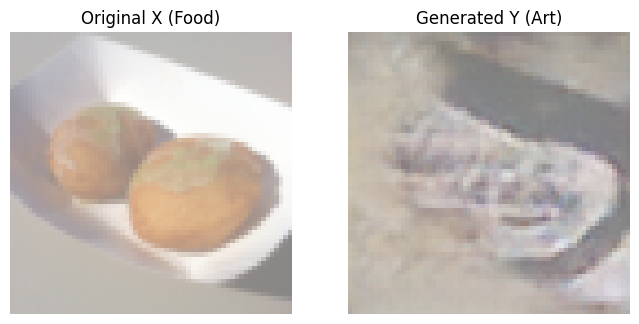

In [ ]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

# put model in eval mode
generator_Y.eval()  # maps X -> Y

# take one batch (or just one image) from the food dataset
sample_X, _ = next(iter(train_dl_X))
sample_X = sample_X.to(device)

# use only one image
img_X = sample_X[0:1]     # shape [1, 3, H, W]

# generate translated image (food -> flower style)
with torch.no_grad():
    fake_Y = generator_Y(img_X)

# helper to denormalize tensor for plotting
def denorm(t):
    out = (t.clamp(-1, 1) + 1) / 2
    return out.cpu().permute(0, 2, 3, 1).squeeze()

# visualize
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(denorm(img_X))
plt.title("Original X (Food)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(denorm(fake_Y))
plt.title("Generated Y (Art)")
plt.axis("off")

plt.show()


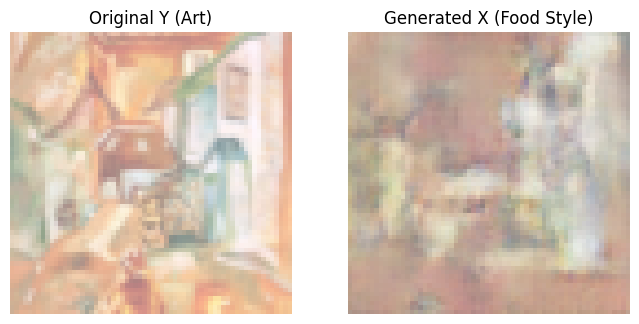

In [ ]:
generator_X.eval()  # maps Y -> X

sample_Y, _ = next(iter(train_dl_Y))
sample_Y = sample_Y.to(device)
img_Y = sample_Y[0:1]

with torch.no_grad():
    fake_X = generator_X(img_Y)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(denorm(img_Y))
plt.title("Original Y (Art)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(denorm(fake_X))
plt.title("Generated X (Food Style)")
plt.axis("off")

plt.show()
